In [4]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] ='6'
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
# import torch
import logging
import time
from argparse import ArgumentParser

# import cv2
# import json_tricks as json
import numpy as np

from multi_camera.datajoint.sessions import Subject, Session, Recording


from pose_pipeline.utils.jupyter import play,play_grid
from pose_pipeline.pipeline import BlurredVideo,LiftingPerson,LiftingMethod,TopDownPerson,Video,TopDownMethodLookup
from multi_camera.datajoint.multi_camera_dj import Calibration,PersonKeypointReconstruction,SingleCameraVideo, CalibratedRecording, MultiCameraRecording,PersonKeypointReconstructionMethod
from hand_detection.hand_dj import HandPoseReconstructionMethodLookup,HandPoseReconstructionMethod, HandPoseReconstruction,HandPoseReconstructionAnalysis,HandPoseEstimationMethodLookup
from hand_detection.hand_dj import HandBbox,HandBboxMethod, HandPoseEstimation,HandPoseEstimationMethod,HandPoseEstimationVideo,MJXReconstruction
from hand_detection.hand_dj import MJXReconstructionVideo,MJXReconstructionAnalysis,HandBboxMethodLookup,HandPoseReconstructionVideo,OpenSimReconstruction,OpenSimReconstructionAnalysis

In [10]:
OpenSimReconstruction.delete()

[2024-06-09 04:50:25,264][INFO]: Deleting 6 rows from `hand_detection`.`__open_sim_reconstruction_analysis`
[2024-06-09 04:50:25,293][INFO]: Deleting 6 rows from `hand_detection`.`__open_sim_reconstruction`
[2024-06-09 04:50:40,017][INFO]: Deletes committed.


6

In [3]:
keys = (Recording& (SingleCameraVideo & 'filename LIKE "%20240524%"')).fetch('KEY')
robust_movi = (PersonKeypointReconstruction & keys &  'top_down_method=12').fetch('KEY')
for k in robust_movi:
    k['reconstruction_method'] = 0
PersonKeypointReconstructionMethod.insert(robust_movi, skip_duplicates=True)
PersonKeypointReconstruction.populate(robust_movi)

In [18]:
from jax import numpy as jnp
jnp.array([0.0]).devices()
from hand_detection.hand_dj import schema
schema.jobs
# OpenSimReconstruction()
keys = (OpenSimReconstruction & (SingleCameraVideo & 'camera_name =23015083')).fetch('KEY')

In [2]:
# MJXReconstructionVideo.populate((MJXReconstruction & 'recording_timestamps="2024-02-20-17:03:30"').fetch('KEY'))
# (MJXReconstructionVideo &   'recording_timestamps="2024-02-20-17:03:30"').fetch('output_video')
(MJXReconstructionAnalysis &   'recording_timestamps="2024-02-20-17:03:30"')

recording_timestamps,camera_config_hash,cal_timestamp,estimation_method,detection_method,pk_5,pk_10,spatial_loss,pose_noise
2024-02-20 17:03:30,6e56d40dc0,2024-02-20 17:13:12,-1,1,0.279226,0.448456,103.391,1.39729
2024-02-20 17:03:30,6e56d40dc0,2024-02-20 17:13:12,-1,2,0.267294,0.445009,103.507,1.39483
2024-02-20 17:03:30,6e56d40dc0,2024-02-20 17:13:12,0,1,0.103137,0.152302,315.548,5.0897
2024-02-20 17:03:30,6e56d40dc0,2024-02-20 17:13:12,0,2,0.0641231,0.101528,358.561,15.1922


In [ ]:
participants = ["yj843","rko5c","8wj64","lgtfc"]
filenames = ['\_L\_%','\_O\_%','\_A\_%','\_D\_%','\_B\_%','\_F\_%']
for filename in filenames:
    for participant_id in participants:
        detection_methods = [1]
        estimation_methods = [0,1]
        # participant_id= participants[1]
        # participant_videos = (Recording & f'participant_id="{participant_id}"').fetch('KEY')
        participant_videos = (Recording & (SingleCameraVideo & f'filename LIKE "{participant_id}{filename}"')).fetch('KEY')
        for rk in participant_videos:
            keys = (CalibratedRecording &(SingleCameraVideo & rk) ).fetch('KEY')
            for estimation_method in estimation_methods:
                for k in keys:
                    k['detection_method'] = 1 
                    k['estimation_method'] = estimation_method     
                print(keys)
                OpenSimReconstruction.populate(keys)#,reserve_keys=True)


In [5]:
HandPoseReconstructionAnalysis.populate((HandPoseReconstruction & 'detection_method=1' & (SingleCameraVideo & f'filename LIKE "%20240524%"')).fetch('KEY'))

In [52]:
participants = ["yj843","rko5c","8wj64","lgtfc"]
# participant_id= participants[1]
participant_videos = (Recording  & (SingleCameraVideo & 'filename LIKE "%20240524%"' )).fetch('KEY')#[i]
# participant_videos = (Recording & f'participant_id="{participant_id}"' & (SingleCameraVideo & 'filename LIKE "%\_D\_%"' )).fetch('KEY')#[i]
# reconstruction_method = 3
from pose_pipeline.pipeline import Video, VideoInfo

key = (HandPoseReconstruction &  participant_videos & 'detection_method=1' & ).fetch('KEY')

In [ ]:
OpenSimReconstruction.populate(key)

In [ ]:
from hand_detection.wrappers.opensim.scaleModel import scale_model, IK_model
import os
# import jax
# from body_models.biomechanics_mjx.implicit_fitting import fetch_keypoints
estimation_method_name =(HandPoseEstimationMethodLookup & key).fetch1('estimation_method_name')
detection_method_name =(HandBboxMethodLookup & key).fetch1('detection_method_name')
base_file_name = (MultiCameraRecording & key).fetch1('video_base_filename')
base_file_name = "_".join(base_file_name.split('_')[:-2])
output_file= f'{os.getcwd()}/{base_file_name}_{estimation_method_name}_{detection_method_name}_smoothed.trc'
pts = HandPoseReconstruction.export_trc((HandPoseReconstruction&key), output_file, z_offset=0, addMovi=True, smooth=True, return_points=True)

pathScaledModel = scale_model('./hand_detection/wrappers/opensim/Models', output_file, 'ARM_Hand_Wrist_Model.osim', '27scales.xml', ['r_x','r_y','r_z'])
pathOutputIK = IK_model('./hand_detection/wrappers/opensim/Models', output_file, pathScaledModel, '27IK.xml')


# kp3d = self.extract_from_osim(pathOutputIK)

In [ ]:
# from hand_detection.hand_dj import schema
# from pose_pipeline.pipeline import schema as pose_schema
# from multi_camera.datajoint.multi_camera_dj import schema as mcschema
# import datajoint as dj
# schema.list_tables()
# (dj.Diagram(schema)).topological_sort()
MJXReconstruction & (HandPoseEstimation & 'filename LIKE "p%"')

In [ ]:
key = (MJXReconstruction & 'detection_method=2' & 'estimation_method=0').fetch('KEY')
# MJXReconstructionVideo.populate(key, display_progress=True)
MJXReconstructionAnalysis.populate((MJXReconstruction & (SingleCameraVideo & 'filename LIKE "%20240124%"')).fetch('KEY'))
# with old calibration m003 {'recording_timestamps': datetime.datetime(2024, 1, 24, 14, 14, 11), 'camera_config_hash': '10d8a3c714', 'cal_timestamp': datetime.datetime(2024, 1, 24, 14, 4, 2), 'estimation_method': -1, 'detection_method': 1, 'pk_5': 0.2352828085422516, 'pk_10': 0.5459096431732178, 'spatial_loss': 6.1621937558422495, 'pose_noise': 0.010687843668284869}


In [ ]:
# from hand_detection.hand_dj import schema
# HandBboxMethod.delete()
(HandPoseReconstruction & (HandBbox & 'filename like "%p71%"'))

In [18]:
vid_keys = (SingleCameraVideo & 'filename LIKE "m005%"').fetch('KEY')
(Calibration &  vid_keys)

cal_timestamp,camera_config_hash,recording_base,num_cameras,camera_names list of camera names,camera_calibration calibration results,reprojection_error,calibration_points,calibration_shape,calibration_type
2024-02-27 15:20:20,7db84d128a,calibration_20240227_152020,8,=BLOB=,=BLOB=,0.061637,=BLOB=,=BLOB=,None


In [6]:
# import datetime
# date_to_restrict = datetime.datetime(2024, 1, 24)
# (Recording * SingleCameraVideo) & "video_project='CUET'" & f'recording_timestamps>"{date_to_restrict}"'

key = (HandPoseReconstruction & (HandBbox & 'filename like "%CUET_1_2%"') & 'estimation_method="1"').fetch('KEY')
HandPoseReconstruction & key 

recording_timestamps,camera_config_hash,cal_timestamp,reconstruction_method,estimation_method,detection_method,keypoints3d,camera_weights,reprojection_loss
2023-05-03 09:12:33,4ff4ccde96,2023-05-03 08:30:05,3,1,1,=BLOB=,=BLOB=,0.405657
2023-09-08 09:36:29,0d55a7bbe2,2023-09-08 09:18:28,3,1,1,=BLOB=,=BLOB=,0.376471
2023-09-08 09:38:43,0d55a7bbe2,2023-09-08 09:18:28,3,1,1,=BLOB=,=BLOB=,0.106902


CUET DATA

In [32]:
vid_keys = (SingleCameraVideo & 'filename LIKE "p71%_R_%"').fetch('KEY')
len(vid_keys)
(Video & (SingleCameraVideo & 'filename LIKE "p71%_R_%"').fetch('KEY')[::12])

[2024-02-20 17:15:57,105][WARNING]: MySQL server has gone away. Reconnecting to the server.


video_project,filename,video datajoint managed video file,start_time,import_time
CUET,p71_CUET_10-11_R_20240215_150537.20150962,=BLOB=,2024-02-15 15:05:37,2024-02-16 10:48:38
CUET,p71_CUET_1_R_20240215_142513.20150962,=BLOB=,2024-02-15 14:25:13,2024-02-16 10:48:52
CUET,p71_CUET_6_R_20240215_144526.20150962,=BLOB=,2024-02-15 14:45:26,2024-02-16 10:49:20
CUET,p71_CUET_6_R_20240215_145208.20150962,=BLOB=,2024-02-15 14:52:08,2024-02-16 10:49:26


In [8]:
# participant_idx = -1 #SESSION_IDX
participant_videos = (Recording & 'participant_id="70"').fetch('KEY')#[participant_idx]
vid_keys= (HandPoseReconstruction & participant_videos).fetch('KEY')
len(vid_keys)
SingleCameraVideo & 'video_project="Wheelchair_propulsion"'

recording_timestamps,camera_config_hash,video_project,filename,camera_name,frame_timestamps
2024-01-25 14:17:38,6222d5655b,WHEELCHAIR_PROPULSION,p70_20240125_141738.23106516,23106516,=BLOB=
2024-01-25 14:17:38,6222d5655b,WHEELCHAIR_PROPULSION,p70_20240125_141738.23106523,23106523,=BLOB=
2024-01-25 14:17:38,6222d5655b,WHEELCHAIR_PROPULSION,p70_20240125_141738.23106526,23106526,=BLOB=
2024-01-25 14:17:38,6222d5655b,WHEELCHAIR_PROPULSION,p70_20240125_141738.23106528,23106528,=BLOB=
2024-01-25 14:17:38,6222d5655b,WHEELCHAIR_PROPULSION,p70_20240125_141738.23106529,23106529,=BLOB=
2024-01-25 14:17:38,6222d5655b,WHEELCHAIR_PROPULSION,p70_20240125_141738.23106530,23106530,=BLOB=
2024-01-25 14:17:38,6222d5655b,WHEELCHAIR_PROPULSION,p70_20240125_141738.23106532,23106532,=BLOB=
2024-01-25 14:17:38,6222d5655b,WHEELCHAIR_PROPULSION,p70_20240125_141738.23106533,23106533,=BLOB=
2024-01-25 14:17:38,6222d5655b,WHEELCHAIR_PROPULSION,p70_20240125_141738.23106539,23106539,=BLOB=
2024-01-25 14:17:38,6222d5655b,WHEELCHAIR_PROPULSION,p70_20240125_141738.23280537,23280537,=BLOB=


Wheelchair data


In [4]:
vid_keys = (SingleCameraVideo & 'filename LIKE "p40_rom_right_20221018_161656%"').fetch('KEY')
len(vid_keys)


10

In [3]:
#Choose first 3 recordings
import datetime
date_to_restrict = datetime.datetime(2024, 1, 24)
# (Recording * SingleCameraVideo) & "video_project='CUET'" & f'recording_timestamps>"{date_to_restrict}"'
participant_videos = (Recording & 'participant_id="m003"' & f'recording_timestamps>="{date_to_restrict}"').fetch('KEY')#[:-1]#[participant_idx]
vid_keys= (SingleCameraVideo & participant_videos & "filename NOT LIKE '%object%'").fetch('KEY')
len(vid_keys)

40

In [2]:
# participant_idx = 1
participant_videos = (Recording & 'participant_id="m003"').fetch('KEY')#[participant_idx]
vid_keys= (SingleCameraVideo & participant_videos).fetch('KEY')
len(vid_keys)

96

In [ ]:
# import datetime
MJXReconstructionVideo.populate(key)
# HandPoseReconstruction & {'recording_timestamps': datetime.datetime(2024, 2, 20, 17, 0, 23)}

In [3]:
from hand_detection.hand_dj import schema
schema.jobs
# schema.jobs.delete()

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp


In [ ]:
keys = (HandBbox & vid_keys & 'detection_method=1').fetch('KEY')
populate_hand_estimation(keys, detection_methods= [1], estimation_methods = [-1,0,1]) 

In [116]:
schema.jobs.delete()

In [51]:
from hand_detection.hand_dj import schema
# schema.jobs.delete()
participants = ["yj843","rko5c","8wj64","lgtfc"]
participant_id = participants[1]
# for participant_id in participants:
participant_videos = (Recording & f'participant_id="{participant_id}"').fetch('KEY')
    # print(len(participant_videos))
HandPoseEstimation & participant_videos

recording_timestamps,camera_config_hash,video_project,filename,detection_method,estimation_method,keypoints_2d


In [90]:
HandBboxMethod & SingleCameraVideo & 'filename LIKE "rko5c_B%"'

recording_timestamps,camera_config_hash,video_project,filename,detection_method


In [117]:
participants = ["yj843","rko5c","8wj64","lgtfc"]
filename = '_L_%'
participant_id= participants[1]
participant_videos = (Recording & f'participant_id="{participant_id}"').fetch('KEY')
participant_videos = (Recording & (SingleCameraVideo & f'filename LIKE "{participant_id}{filename}"')).fetch('KEY')
detection_methods = [1,2]
estimation_methods = [0]
# reconstruction_methods = [3]

print("Processing", len(participant_videos), "Recordings")
for rk in participant_videos:
    keys = (SingleCameraVideo & rk ).fetch('KEY')
    populate_hand_estimation(keys,  detection_methods= detection_methods, estimation_methods = estimation_methods)


Processing 2 Recordings
{'recording_timestamps': datetime.datetime(2024, 5, 24, 14, 41, 59), 'camera_config_hash': '39932d9e29', 'video_project': 'HAND_TEST', 'filename': 'rko5c_L_20240524_144159.23336088', 'detection_method': 1, 'estimation_method': 0}
Populating Hand Estimation  rko5c L 1 0
{'recording_timestamps': datetime.datetime(2024, 5, 24, 14, 41, 59), 'camera_config_hash': '39932d9e29', 'video_project': 'HAND_TEST', 'filename': 'rko5c_L_20240524_144159.23336088', 'detection_method': 2, 'estimation_method': 0}
Populating Hand Estimation  rko5c L 2 0
{'recording_timestamps': datetime.datetime(2024, 5, 24, 14, 52, 3), 'camera_config_hash': '39932d9e29', 'video_project': 'HAND_TEST', 'filename': 'rko5c_L_20240524_145203.23336088', 'detection_method': 1, 'estimation_method': 0}
Populating Hand Estimation  rko5c L 1 0
{'recording_timestamps': datetime.datetime(2024, 5, 24, 14, 52, 3), 'camera_config_hash': '39932d9e29', 'video_project': 'HAND_TEST', 'filename': 'rko5c_L_20240524_145

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:40<00:00, 23.61it/s]


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:39<00:00, 24.45it/s]


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:41<00:00, 22.82it/s]


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:37<00:00, 25.43it/s]


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:39<00:00, 24.17it/s]


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:38<00:00, 24.98it/s]


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:41<00:00, 23.03it/s]


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:42<00:00, 22.53it/s]


In [109]:

def populate_hand_bbox(keys, detection_methods = [1]):
    for detection_method in detection_methods:
        for k in keys:
            k['detection_method'] = detection_method 
        HandBboxMethod.insert(keys,skip_duplicates=True)
        print("HandBbox Populate ", 
              ' '.join((SingleCameraVideo & k).fetch1('filename').split('_')[:2]),
              detection_method)
        HandBbox.populate(keys)

def populate_hand_estimation(keys, detection_methods= [1], estimation_methods = [-1]): 
    for detection_method in detection_methods:
        for estimation_method in estimation_methods:
            for k in keys:
                k['detection_method'] = detection_method 
                k['estimation_method'] = estimation_method     
            print(k)
            HandPoseEstimationMethod.insert(keys,skip_duplicates=True)
            print("Populating Hand Estimation ", 
                  ' '.join((SingleCameraVideo & k).fetch1('filename').split('_')[:2]),
                  detection_method, estimation_method)
            HandPoseEstimation.populate(keys, reserve_jobs=True)

def populate_hand_reconstruction(keys, detection_methods=[1], estimation_methods = [-1], reconstruction_methods =[3]):
    for detection_method in detection_methods:
        for estimation_method in estimation_methods:
            for reconstruction_method in reconstruction_methods:
                for k in keys:
                    k['detection_method'] = detection_method
                    k['estimation_method'] = estimation_method
                    k['reconstruction_method'] = reconstruction_method 
                HandPoseReconstructionMethod.insert(keys,skip_duplicates=True)
                print("Hand Reconstruction Populate ", 
                      ' '.join((SingleCameraVideo & k).fetch1('filename').split('_')[:2]),
                      detection_method, estimation_method)
                HandPoseReconstruction.populate(keys,reserve_jobs=True)


# keys_list = ['filename LIKE "p73%"']#['filename LIKE "m002%"','filename LIKE "p40_rom_right_20221018_161656%"']
# detection_methods = [1,2]
# estimation_methods = [-1,0]#range(-1,5)
# reconstruction_methods = [3]

# for name in keys_list:
#     recording_keys = (Recording & (SingleCameraVideo & name )).fetch('KEY')[1:]
#     print("Processing", len(recording_keys), "Recordings")
#     for rk in recording_keys:
#         keys = (SingleCameraVideo & rk ).fetch('KEY')
#         populate_hand_bbox(keys, detection_methods = detection_methods)

#     for rk in recording_keys:
#         keys = (SingleCameraVideo & rk ).fetch('KEY')
#         populate_hand_estimation(keys,  detection_methods= detection_methods, estimation_methods = estimation_methods)

#     for rk in recording_keys:
#         # # populate pose reconstruction as well       
#         keys = (SingleCameraVideo & rk ).fetch('KEY')
#         key = (CalibratedRecording & (HandPoseEstimation & keys)).fetch('KEY')
#         populate_hand_reconstruction(key, detection_methods = detection_methods, 
#                                      estimation_methods = estimation_methods, 
#                                      reconstruction_methods = reconstruction_methods)


In [26]:
key = (HandPoseReconstruction & (Recording & (HandPoseEstimation & 'filename like "%p73%"')).fetch('KEY')[0]).fetch('KEY')
(BlurredVideo & (SingleCameraVideo & key)).fetch('output_video')
BlurredVideo.populate((SingleCameraVideo & key).fetch('KEY'))

In [26]:
HandPoseReconstruction & recording_keys[3]

recording_timestamps,camera_config_hash,cal_timestamp,reconstruction_method,estimation_method,detection_method,keypoints3d,camera_weights,reprojection_loss
2024-02-15 15:05:37,6e56d40dc0,2024-02-15 16:02:49,3,-1,1,=BLOB=,=BLOB=,23.4634
2024-02-15 15:05:37,6e56d40dc0,2024-02-15 16:02:49,3,-1,2,=BLOB=,=BLOB=,23.4634
2024-02-15 15:05:37,6e56d40dc0,2024-02-15 16:02:49,3,0,1,=BLOB=,=BLOB=,63.3362
2024-02-15 15:05:37,6e56d40dc0,2024-02-15 16:02:49,3,0,2,=BLOB=,=BLOB=,2.63181


In [41]:
HandPoseEstimation & 'detection_method=1'

recording_timestamps,camera_config_hash,video_project,filename,detection_method,estimation_method,keypoints_2d


In [40]:
HandPoseEstimation * SingleCameraVideo & {
                "estimation_method": -1,
                # "detection_method" : 1,
                "reconstruction_method": 3,
            } & (MultiCameraRecording & key)

recording_timestamps,camera_config_hash,video_project,filename,detection_method,estimation_method,keypoints_2d,camera_name,frame_timestamps
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106516,2,-1,=BLOB=,23106516,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106523,2,-1,=BLOB=,23106523,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106526,2,-1,=BLOB=,23106526,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106528,2,-1,=BLOB=,23106528,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106529,2,-1,=BLOB=,23106529,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106530,2,-1,=BLOB=,23106530,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106532,2,-1,=BLOB=,23106532,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106533,2,-1,=BLOB=,23106533,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23106539,2,-1,=BLOB=,23106539,=BLOB=
2023-11-15 14:45:52,6222d5655b,HAND_TEST,m002_20231115_144552.23280537,2,-1,=BLOB=,23280537,=BLOB=


In [35]:
(
            HandPoseEstimation * SingleCameraVideo * MultiCameraRecording
            & {
                "estimation_method": -1,
                "detection_method" : 1,
                "reconstruction_method": 3,
            }
            &  ((MultiCameraRecording & key).fetch1("KEY"))
)

recording_timestamps,camera_config_hash,video_project,filename,detection_method,estimation_method,keypoints_2d,camera_name,frame_timestamps,video_base_filename


In [26]:
key = (CalibratedRecording & (HandPoseEstimation & keys)).fetch('KEY')
key

[{'recording_timestamps': datetime.datetime(2023, 11, 15, 14, 45, 52),
  'camera_config_hash': '6222d5655b',
  'cal_timestamp': datetime.datetime(2023, 11, 15, 14, 49, 30)}]

In [3]:
for k in vid_keys:
    k['detection_method'] = 2
len(vid_keys)

96

In [9]:
(HandBboxMethod&vid_keys).delete()

[2024-02-15 14:54:33,497][INFO]: Deleting 12 rows from `hand_detection`.`hand_bbox_method`
[2024-02-15 14:54:38,539][INFO]: Deletes committed.


12

In [12]:
HandBboxMethod.insert(vid_keys,skip_duplicates=True)
HandBbox.populate(vid_keys)
# len((HandBbox & "detection_method=1").fetch('KEY'))

In [ ]:
(TopDownPerson & vid_keys & "top_down_method=2") * SingleCameraVideo & "camera_name='23106523'"
# keypoints = (TopDownPerson & vid_keys[0] & "top_down_method=2").fetch1("keypoints")

In [4]:
HandPoseEstimation & vid_keys 

recording_timestamps,camera_config_hash,video_project,filename,detection_method,estimation_method,keypoints_2d
2024-01-24 14:14:11,10d8a3c714,HAND_TEST,m003_static_20240124_141411.23106523,2,-1,=BLOB=
2024-01-24 14:14:11,10d8a3c714,HAND_TEST,m003_static_20240124_141411.23106523,2,0,=BLOB=
2024-01-24 14:14:11,10d8a3c714,HAND_TEST,m003_static_20240124_141411.23106526,2,-1,=BLOB=
2024-01-24 14:14:11,10d8a3c714,HAND_TEST,m003_static_20240124_141411.23106526,2,0,=BLOB=
2024-01-24 14:14:11,10d8a3c714,HAND_TEST,m003_static_20240124_141411.23106529,2,-1,=BLOB=
2024-01-24 14:14:11,10d8a3c714,HAND_TEST,m003_static_20240124_141411.23106529,2,0,=BLOB=
2024-01-24 14:14:11,10d8a3c714,HAND_TEST,m003_static_20240124_141411.23106533,2,-1,=BLOB=
2024-01-24 14:14:11,10d8a3c714,HAND_TEST,m003_static_20240124_141411.23106533,2,0,=BLOB=
2024-01-24 14:14:11,10d8a3c714,HAND_TEST,m003_static_20240124_141411.23106539,2,-1,=BLOB=
2024-01-24 14:14:11,10d8a3c714,HAND_TEST,m003_static_20240124_141411.23106539,2,0,=BLOB=


In [14]:
for k in vid_keys:
    k['estimation_method'] = 0
len(vid_keys)
# HandPoseEstimationMethod.insert(vid_keys,skip_duplicates=True)
# ((HandPoseEstimationMethod & vid_keys))

12

In [47]:
for i in range(5):
    for k in vid_keys:
        k['estimation_method'] = i
    len(vid_keys)
    HandPoseEstimationMethod.insert(vid_keys,skip_duplicates=True)
    # HandPoseEstimation.populate(vid_keys)
# len((HandPoseEstimation & "detection_method=1" ).fetch('KEY'))
# HandPoseEstimation & vid_keys

In [ ]:
HandPoseEstimation.populate()
(HandPoseEstimation & vid_keys).fetch('keypoints_2d')[0].shape

# Visualization

In [4]:
from pose_pipeline.utils.visualization import draw_keypoints
from tqdm import tqdm
def render_video(video, output_file, keypoints):
    cap = cv2.VideoCapture(video)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = cap.get(cv2.CAP_PROP_FPS)
    output_size = (int(w),int(h))

    fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    out = cv2.VideoWriter(output_file,fourcc, fps,output_size)

    for frame_idx in tqdm(range(total_frames)):
        success, frame = cap.read()

        if not success:
            break
        keypoints = keypoints[frame_idx,:,:].copy()
        frame = draw_keypoints(frame,keypoints)
        out.write(frame)

    out.release()
    cap.release()

In [6]:

num_cameras = len(vid_keys)
num_cameras

96

In [27]:
from tqdm import tqdm
def plot_all_cameras(key, frame_idx = 0,n_cols=3):
    # using the variable axs for multiple Axes
    from pose_pipeline.utils.visualization import draw_keypoints
    
    
    vid_keys = (HandPoseEstimation * SingleCameraVideo & key).fetch('KEY')
    movi_tables = TopDownPerson * TopDownMethodLookup * SingleCameraVideo & 'top_down_method_name="Bridging_bml_movi_87"'

    moviinds = np.array((3,2,39,41,43,44,57))

    movi_keypoints = (movi_tables & key).fetch("keypoints")
    movi_keypoints = np.stack(
            [k[:,moviinds,:] for k in movi_keypoints], axis=0
        )
    num_cameras = len(vid_keys)
    bbox_keys = (HandPoseEstimation * SingleCameraVideo & key).fetch('KEY')
    # for k in bbox_keys:
    #     k['detection_method'] = 2
    bbox_keys = (HandBbox & bbox_keys).fetch('KEY')

    fig, axs = plt.subplots(num_cameras//n_cols,n_cols,figsize=(15,15))
    for vid_idx in tqdm(range(num_cameras)):
        vid_file = ( Video & vid_keys[vid_idx]).fetch('video')[0]
        # output_file = f'{output_root}m002_camera{vid_idx}.mp4'
        
        cap = cv2.VideoCapture(vid_file)
        # frame_idx = 0
        # video_writer = None
        # pred_instances_list = []
        keypoints_2d = (HandPoseEstimation & vid_keys[vid_idx]).fetch1("keypoints_2d")
        ###############################CHOOSE A FRAME#########################
        # while frame_idx < 1:
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        # print(h,w)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        success, frame = cap.read()
        # frame_idx += 1
        bboxes = np.asarray((HandBbox & bbox_keys[vid_idx]).fetch1("bboxes"))
        # bbox = np.min(bboxes,axis=0)-100
        # bbox[...,-2:]= np.max(bboxes,axis=0)[-2:]+100
        if not success:
            break
        # radius = 10
        # threshold = 0.2
        # color = (255,255,255)
        # border_color = (0,0,0)
        keypoints = keypoints_2d[frame_idx,:,:]
        mvkp = movi_keypoints[vid_idx,frame_idx,:]
        frame = draw_keypoints(frame,keypoints,threshold=0.1)
        frame = draw_keypoints(frame,mvkp,threshold=0.1)
        
        for bbox in bboxes[frame_idx]:
            frame = cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)  # Green color, 2 pixel thickness
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        row = vid_idx // n_cols
        col = vid_idx % n_cols
        axs[row,col].imshow(frame)
        axs[row,col].axis('off')
        os.remove(vid_file)
    

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


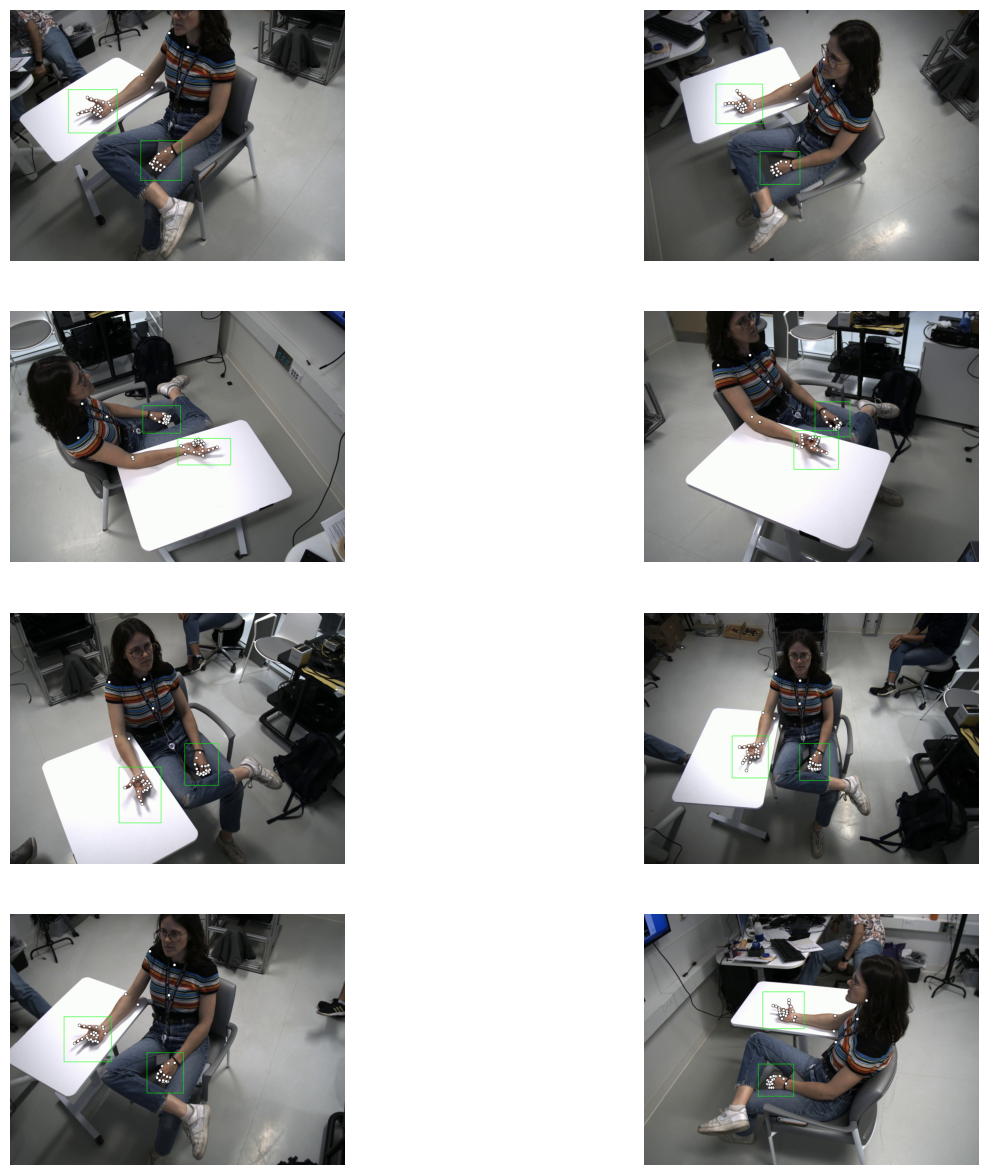

In [28]:
%matplotlib inline
participant_videos = (Recording & participant_videos).fetch('KEY')
for p in participant_videos:
    p['detection_method'] = 1
    p['estimation_method'] = 0

plot_all_cameras(participant_videos[0], frame_idx = 400, n_cols=2)

In [ ]:
from hand_detection.wrappers.hand_estimation import plot_triangulated_keypoints
key = participant_videos[0]
kp3d = (MJXReconstruction & key).fetch('sites')*1000.0
results = plot_triangulated_keypoints(key, kp3d, only_osim = False,useBlurred = True, crop_bbox = False)


# fourcc = cv2.VideoWriter_fourcc(*"mp4v")
# out = cv2.VideoWriter(filename,fourcc, fps,output_size)

# #process every frame
# for frame_idx in tqdm(range(total_frames)):
#     out.write(frame)



In [20]:
keys = (HandPoseEstimation & (HandPoseReconstruction & vid_keys & 'estimation_method=-1').fetch('KEY')).fetch('KEY')

In [21]:
HandPoseReconstruction & keys

recording_timestamps,camera_config_hash,cal_timestamp,reconstruction_method,estimation_method,detection_method,keypoints3d,camera_weights,reprojection_loss
2024-01-24 14:14:11,10d8a3c714,2024-01-24 14:30:40,3,-1,1,=BLOB=,=BLOB=,35.1193
2024-01-24 14:15:32,10d8a3c714,2024-01-24 14:30:40,3,-1,1,=BLOB=,=BLOB=,43.2404
2024-01-24 14:16:22,10d8a3c714,2024-01-24 14:30:40,3,-1,1,=BLOB=,=BLOB=,34.994
2024-01-24 14:19:48,10d8a3c714,2024-01-24 14:30:40,3,-1,1,=BLOB=,=BLOB=,30.4827
2024-01-24 14:20:47,10d8a3c714,2024-01-24 14:30:40,3,-1,1,=BLOB=,=BLOB=,39.1691


In [22]:
HandPoseReconstructionVideo.populate(keys)

No MOVI data found for robust triangulation
Using implicit optimization for MOVI


Writing: 100%|██████████| 932/932 [00:24<00:00, 37.83it/s]


No MOVI data found for robust triangulation
Using implicit optimization for MOVI


Writing: 100%|██████████| 635/635 [00:15<00:00, 41.47it/s]


No MOVI data found for robust triangulation
Using implicit optimization for MOVI


Writing: 100%|██████████| 578/578 [00:16<00:00, 35.21it/s]


No MOVI data found for robust triangulation
Using implicit optimization for MOVI


Writing: 100%|██████████| 991/991 [00:23<00:00, 42.26it/s]


No MOVI data found for robust triangulation
Using implicit optimization for MOVI


Writing: 100%|██████████| 1475/1475 [00:35<00:00, 41.85it/s]


In [24]:
(HandPoseReconstructionVideo & keys).fetch('output_video')

array(['tmp4bg7whaz.mp4', 'tmpqxbpfah6.mp4', 'tmpuz31c99s.mp4',
       'tmpeqethdkf.mp4', 'tmpnwd7fw6c.mp4'], dtype=object)

In [50]:
key = (CalibratedRecording * (HandPoseEstimation & vid_keys)).fetch('KEY')
for k in key:
    k.pop('video_project')
    k.pop('filename')
    k['reconstruction_method']=3
HandPoseReconstructionMethod.insert(key,skip_duplicates=True)
HandPoseReconstruction.populate(key)


{'recording_timestamps': datetime.datetime(2023, 11, 15, 14, 46, 31), 'camera_config_hash': '6222d5655b', 'cal_timestamp': datetime.datetime(2023, 11, 15, 14, 49, 30), 'reconstruction_method': 3, 'estimation_method': 0, 'detection_method': 2}
(12,)
2
{'recording_timestamps': datetime.datetime(2023, 11, 15, 14, 46, 31), 'camera_config_hash': '6222d5655b', 'cal_timestamp': datetime.datetime(2023, 11, 15, 14, 49, 30), 'reconstruction_method': 3, 'estimation_method': 0, 'detection_method': 2}
(12, 917, 42, 3)
CAMERAS 12
(12, 917, 42, 3)
Robust Triangulation $\\gamma=0.3$


In [ ]:
for i in range(5):
    key = (CalibratedRecording * (HandPoseEstimation & vid_keys)).fetch('KEY')
    for k in key:
        k.pop('video_project')
        k.pop('filename')
        k['reconstruction_method']=3
        k['estimation_method'] = i
    HandPoseReconstructionMethod.insert(key,skip_duplicates=True)
    HandPoseReconstruction.populate()


In [ ]:
HandPoseEstimationVideo.populate()

# Export to TRC files


In [63]:
Recording & vid_keys 

participant_id,session_date,recording_timestamps,camera_config_hash,comment
40,2022-10-18,2022-10-18 11:16:56,4ff4ccde96,


# Populate and export trc


In [64]:
# participant_idx = 1
# participant_id="m002"
participant_videos = (Recording & vid_keys).fetch('KEY')#[participant_idx]
reconstruction_method = 3

key = (CalibratedRecording &  participant_videos).fetch('KEY')
for k in key:
    k['reconstruction_method']= reconstruction_method
    k['estimation_method']=-1
    k['detection_method']=1
(key)
# participant_idx = 1
# participant_id="m002"
# participant_videos = (Recording & f'participant_id="m002"').fetch('KEY')[1]
# reconstruction_method = 3

# keys = (HandPoseReconstruction & CalibratedRecording &  participant_videos).fetch('KEY')
# for k in keys:
#     k['reconstruction_method']= reconstruction_method
#     # k['estimation_method']=1
#     k['detection_method']=1
# # key = key[0]
# (HandPoseReconstruction & keys)

[{'recording_timestamps': datetime.datetime(2022, 10, 18, 11, 16, 56),
  'camera_config_hash': '4ff4ccde96',
  'cal_timestamp': datetime.datetime(2022, 10, 18, 8, 20, 13),
  'reconstruction_method': 3,
  'estimation_method': -1,
  'detection_method': 1}]

In [65]:

HandPoseReconstructionMethod.insert(key,skip_duplicates=True)
HandPoseReconstruction.populate(key)


In [26]:
participant_id= "m002"
participant_videos = (Recording & f'participant_id="{participant_id}"').fetch('KEY')#[i]
(MJXReconstruction & CalibratedRecording &  participant_videos)
# (Recording & f'participant_id="{participant_id}"')


recording_timestamps,camera_config_hash,cal_timestamp,estimation_method,detection_method,body_scale,site_offsets,mean_reprojection_loss,site_offset_loss,timestamps,qpos,qvel,joints,sites
2023-11-15 14:45:52,6222d5655b,2023-11-15 14:49:30,-1,1,=BLOB=,=BLOB=,36.7518,0.0219385,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
2023-11-15 14:45:52,6222d5655b,2023-11-15 14:49:30,-1,2,=BLOB=,=BLOB=,36.6156,0.0218886,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
2023-11-15 14:45:52,6222d5655b,2023-11-15 14:49:30,0,1,=BLOB=,=BLOB=,16.7481,0.0161305,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
2023-11-15 14:45:52,6222d5655b,2023-11-15 14:49:30,0,2,=BLOB=,=BLOB=,16.4993,0.0176168,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
2023-11-15 14:45:52,6222d5655b,2023-11-15 14:49:30,1,1,=BLOB=,=BLOB=,14.0039,0.0130758,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
2023-11-15 14:45:52,6222d5655b,2023-11-15 14:49:30,1,2,=BLOB=,=BLOB=,14.0288,0.0132328,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
2023-11-15 14:45:52,6222d5655b,2023-11-15 14:49:30,2,1,=BLOB=,=BLOB=,19.4295,0.0133927,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
2023-11-15 14:45:52,6222d5655b,2023-11-15 14:49:30,2,2,=BLOB=,=BLOB=,21.1512,0.0216656,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
2023-11-15 14:45:52,6222d5655b,2023-11-15 14:49:30,3,1,=BLOB=,=BLOB=,24.306,0.0798081,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
2023-11-15 14:45:52,6222d5655b,2023-11-15 14:49:30,3,2,=BLOB=,=BLOB=,22.4594,0.0752102,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation for MOVI
Using robust triangulation f

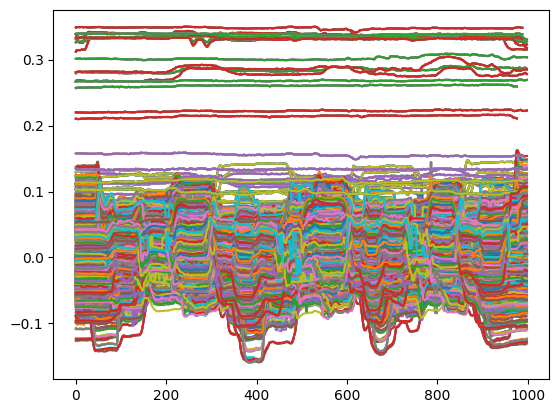

In [12]:
# participant_id= "m002"
root = f'./trace_files/A'
# for i in range(1):
#     for ii in range (5):
    # participant_idx = i
keys = (Recording& (SingleCameraVideo & 'filename LIKE "%\_A\_%20240524%"')).fetch('KEY')
keys = (MJXReconstruction & keys).fetch('KEY')
# participant_videos = (Recording & f'participant_id="{participant_id}"').fetch('KEY')#[i]
# reconstruction_method = 3
from pose_pipeline.pipeline import Video, VideoInfo
# for i in range(len(participant_videos)):
#     keys = (HandPoseReconstruction & CalibratedRecording &  participant_videos[i]).fetch('KEY')
    # for k in key:
        # k['reconstruction_method']= reconstruction_method
        # k['estimation_method']=ii
        # k['detection_method']=1
for ii, key in enumerate(keys):
        # key['reconstruction_method'] = 2
        # key['top_down_method']=12
        # key['tracking_method']=21
        # key.pop('estimation_method')
        # key.pop('detection_method')
        # key.pop('reconstruction_method')
        # PersonKeypointReconstructionMethod.insert([key])
        # PersonKeypointReconstruction.populate([key])
        estimation_method_name =(HandPoseEstimationMethodLookup & key).fetch1('estimation_method_name')
        detection_method_name =(HandBboxMethodLookup & key).fetch1('detection_method_name')
        base_file_name = (MultiCameraRecording & key).fetch1('video_base_filename')
        self = (HandPoseReconstruction & key )
        base_file_name = "_".join(base_file_name.split('_')[:-2])
        output_file= f'{root}/{estimation_method_name}_{detection_method_name}_{base_file_name}_{ii}_smoothed.trc'
        pts = HandPoseReconstruction.export_trc(self, output_file, z_offset=0, addMovi=True, smooth=True, return_points=True)
        plt.plot(pts[...,0])


In [45]:
PersonKeypointReconstruction & keys

recording_timestamps,camera_config_hash,cal_timestamp,reconstruction_method,tracking_method,top_down_method,keypoints3d,camera_weights,reprojection_loss,skeleton_loss,smoothness_loss


In [ ]:
(HandPoseReconstruction & key ).fetch("reprojection_loss")

In [ ]:
(HandPoseReconstruction & key ).fetch("reprojection_loss")

kp3d = (HandPoseReconstruction & key ).fetch1("keypoints3d")
# np.where(kp3d==0)
kp2d = (HandPoseEstimation & SingleCameraVideo & key).fetch("keypoints_2d")[4]
kp2d = np.asarray(kp2d)
kp2d_r = kp2d[:,0,:,:]
plt.plot(kp2d_r[250:350,17:,0])
plt.yticks([])
plt.legend(range(17,21))
# plt.plot(kp2d_r[:,15:,2])
plt.pause(0.5)
plt.plot(kp2d_r[250:350,17:,2])
plt.pause(0.5)
plt.plot(kp3d[250:350,17:21,2])
plt.legend(range(17,21))
plt.yticks([])
# # np.where(kp2d==0)
# plt.pause(0.5)
# plt.plot(kp3d[250:350,17:21,3])
# plt.legend(range(17,21))
plt.yticks([])
np.unique(np.where(kp3d[...,-1]==0)[0]).shape

In [ ]:
for j in range(20,21):
    HandPoseReconstruction.plot_joint((HandPoseReconstruction & key ),j)
    plt.pause(0.5)
    

In [ ]:
(HandPoseEstimationVideo & (HandPoseEstimationVideo & key).fetch('KEY')[5]).fetch('output_video')

# project all keypoints in a video

In [2]:
participant_idx = 1
participant_id="rkoc5"
participant_videos = (Recording & f'participant_id="m002"').fetch('KEY')[participant_idx]
reconstruction_method = 3

key = (CalibratedRecording &  participant_videos).fetch('KEY')
for k in key:
    k['reconstruction_method']= reconstruction_method
    k['estimation_method']=0
    k['detection_method']=1
(HandPoseReconstruction & key)

recording_timestamps,camera_config_hash,cal_timestamp,reconstruction_method,estimation_method,detection_method,keypoints3d,camera_weights,reprojection_loss
2023-11-15 14:46:31,6222d5655b,2023-11-15 14:49:30,3,0,1,=BLOB=,=BLOB=,4.09316


In [3]:
import pandas as pd
import numpy as np
def extract_from_osim(filename):
    # Read the ".sto" file into a Pandas DataFrame
    markerDF = pd.read_csv(filename, sep='\t',skiprows=6)
    # Display the DataFrame
    markerDFkeys = markerDF.keys().values
    # extract time and markers
    markerKeys = np.array([marker.split('_')[0] for marker in markerDFkeys[1:]])[::3]
    #Extract the coordinates of all markers except time
    markersNP = markerDF.drop(columns =['time'])
    points3d = markersNP.values.reshape(markerDF.shape[0], markerKeys.shape[0], 3)
    theta = np.pi
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    #rotate markers 180 along Y similar to extract trc file
    points3d = points3d@rotation_matrix
    points3d = np.take(points3d, [2, 0, 1], axis=-1)
    keypoints3dOSIM = points3d
    timeOSIM = markerDF['time'].values

    #map the markers to joint_names to be exactly same as extracted previously
    markerKeysDict ={element: index for index, element in enumerate(markerKeys)}
    # Compare elements to original indices in joint_names
    joint_names = ['Wrist','CMC1','MCP1','IP1','TIP1','MCP2','PIP2',
        'DIP2', 'TIP2', 'MCP3', 'PIP3', 'DIP3','TIP3', 'MCP4',
        'PIP4', 'DIP4', 'TIP4', 'MCP5', 'PIP5','DIP5', 'TIP5']
    if 'Dark' in filename: 
        joint_names = ['Wrist','TIP1','IP1','MCP1','CMC1','TIP2','DIP2','PIP2','MCP2',
                      'TIP3','DIP3','PIP3','MCP3','TIP4', 'DIP4',  'PIP4', 'MCP4',
                      'TIP5','DIP5', 'PIP5','MCP5']
    # joint_names =  (HandPoseEstimation&key).joint_names()
    movi_joints= [  
                "R.clavicle",#2
                "R.Shoulder.M",#39
                "R.Elbow.Lateral",#41
                # "R.Forearm",#42
                "R.Wrist.Lateral.Thumb",#43
                "R.Wrist.Medial.pinky",#44
                "R.Elbow.Medial.Inner",#57
                ]
    joint_names = movi_joints + joint_names
    markerMapping = [markerKeysDict[element] for index, element in enumerate(joint_names)]
    sorted_markerKeys = markerKeys[markerMapping]
    sorted_keypoints3dOSIM = keypoints3dOSIM[:,markerMapping,:]
    # #add the ground back to the keypoints
    # for jj in range (sorted_keypoints3dOSIM.shape[1]):
    #     sorted_keypoints3dOSIM[:,jj] = sorted_keypoints3dOSIM[:, jj] + groundRef
    #Go back to mm from m
    kp3dOsim = sorted_keypoints3dOSIM * 1000 
    return kp3dOsim

# def overlay_osim_keypoints(key, osim_file):
#     # sto_file_path = './m002_Test02_ik_marker_locations.sto'
  


In [8]:
        
import tempfile
from tqdm import tqdm
def plot_osim_triangulated_keypoints(key, kp3dOsim, frame_index = 0):
    from multi_camera.datajoint.multi_camera_dj import Calibration
    from multi_camera.analysis.camera import project_distortion, get_intrinsic, get_extrinsic, distort_3d

    from pose_pipeline.pipeline import Video, VideoInfo
    from pose_pipeline.utils.visualization import video_overlay, draw_keypoints
    import cv2
    from pose_pipeline.utils.bounding_box import crop_image_bbox, fix_bb_aspect_ratio

    # kp3d = (HandPoseReconstruction & key ).fetch1("keypoints3d")

    # keys = (Recording & key).fetch('KEY')
    videos = (HandPoseEstimation * MultiCameraRecording * SingleCameraVideo & Recording & key).proj()
    camera_params= (Recording * Calibration & key).fetch1("camera_calibration")
    camera_names = (Recording * Calibration & key).fetch1("camera_names")
    video_keys = (videos).fetch("KEY")
    fps = np.unique((VideoInfo & video_keys[0]).fetch1("fps"))
    width = np.unique((VideoInfo & video_keys).fetch("width"))[0]
    height = np.unique((VideoInfo & video_keys).fetch("height"))[0]

    total_frames = int(np.unique((VideoInfo & video_keys[0]).fetch1("num_frames")))

    keypoints_2d_OSIM = np.array([project_distortion(camera_params, i, kp3dOsim) for i in range(camera_params["mtx"].shape[0])])
    # keypoints_2d_triangulated = np.array([project_distortion(camera_params, i, kp3d) for i in range(camera_params["mtx"].shape[0])])

    num_cameras = len(camera_names)
    results = []
    if frame_index >= 0:
        n_cols = 3
        fig, axs = plt.subplots(num_cameras//n_cols,n_cols,figsize=(15,15)) 
    
    for ci in range(num_cameras):
        cam_idx = ci
        
        i = cam_idx
        # get camera parameters
        K = np.array(get_intrinsic(camera_params, i))

        # don't use real extrinsic since we apply distortion which does this
        R = np.eye(3)
        T = np.zeros((3,))
        cameras = {"K": [K], "R": [R], "T": [T]}


        background = np.ones((height, width, 3), dtype=np.uint8) * 127
        vid_file = (Video & video_keys[i]).fetch1("video")
        vid = cv2.VideoCapture(vid_file)

        kp2d_camera = np.asarray((HandPoseEstimation & video_keys[ci]).fetch1("keypoints_2d"))
        kp2d_camera = kp2d_camera.reshape(kp2d_camera.shape[0], -1, kp2d_camera.shape[-1])    
        bboxes = np.asarray((HandBbox & video_keys[ci]).fetch1('bboxes'))
        bboxes = bboxes[:,0,:]

        bbox = np.min(bboxes,axis=0)
        bbox[-2:]= np.max(bboxes,axis=0)[-2:]
        # bbox[:2] -= bbox[:2]/2
        # bbox[-2:] += bbox[-2:]/2
        
        def render_overlay(frame, idx, frame_idx):
            raw_frame = frame.copy()

            #GREEN
            color = (30, 200, 30)
            raw_frame = draw_keypoints(raw_frame, np.array(kp2d_camera[frame_idx,:21]), radius=5, threshold=0.10, border_color=color, color=color)
            
            #Red
            color = (30, 30, 200)
            # raw_frame = draw_keypoints(raw_frame, np.array(keypoints_2d_triangulated[idx, frame_idx]), radius=3, threshold=0.10, border_color=color, color=color)

            #Blue
            color = (200, 30, 30)
            raw_frame = draw_keypoints(raw_frame, np.array(keypoints_2d_OSIM[idx, frame_idx]), radius=5, threshold=0.10, border_color=color, color=color)


            raw_frame = cv2.cvtColor(raw_frame, cv2.COLOR_BGR2RGB)

            # raw_frame = crop_image_bbox(
            #     raw_frame, bboxes[frame_idx], target_size=(288, int(288 * 1920 / 1080)), dilate=1.0
            # )[0]
            target_size= (288, int(288 * 1920 / 1080))
            dilate= 1.4 
            image = raw_frame
            # bbox = bboxes[frame_idx]            
            # bbox = fix_bb_aspect_ratio(bbox, ratio=target_size[0] / target_size[1], dilate=dilate)
            
            # three points on corner of bounding box
            src = np.asarray([[bbox[0], bbox[1]], [bbox[2] ,bbox[3]], [bbox[0], bbox[3]]])
            dst = np.array([[0, 0], [target_size[0], target_size[1]], [0, target_size[1]]])  # .astype(np.float32)
            trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))
            image = cv2.warpAffine(image, trans, target_size, flags=cv2.INTER_LINEAR)

            return image
        
        def make_frames():
            list_frames = []
            vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
            for frame_num in tqdm(range(total_frames)):
                # print(frame_num, '|', kp3d.shape[0])
                _, frame = vid.read()
                frame = render_overlay(frame, cam_idx, frame_num)
                list_frames.append(frame)
            return list_frames
        
        if frame_index == -1:
            results.append(make_frames())
        else:
            
            vid.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = vid.read()
            row = ci // n_cols
            col = ci % n_cols
            axs[row,col].imshow(render_overlay(frame,cam_idx,frame_index))

        os.remove(vid_file)
        vid.release()

    if frame_index == -1:
        return results

In [13]:
import os

# Replace 'your_directory' with the path to the directory you want to search in
kp3dOsim = extract_from_osim("./m002_trial1_RTMPoseHand5_TopDown_smoothed_ik_model_marker_locations.sto")
# dic = {}
# for root, dirs, files in os.walk('./'):
#     for filename in files:
#         if filename == '_ik_model_marker_locations.sto':
#             file = os.path.join(root, filename)
#             print(file)
#             kp3dOsim = extract_from_osim(file)
#             dic[root] = kp3dOsim


In [22]:
# key[0]['estimation_method'] = 0
# for kp3dOsim in dic.values():
#     results = plot_osim_triangulated_keypoints(key, kp3dOsim, 275)
participant_videos = (Recording & (SingleCameraVideo & f'filename LIKE "%\_L_20240524%"')).fetch('KEY')
key = (MJXReconstruction & participant_videos & 'estimation_method = 0' & 'detection_method=1').fetch('KEY')[0]
kp3d = (MJXReconstruction & key).fetch1('sites')*1000.0
# keys = (HandPoseEstimation & (SingleCameraVideo & 'filename LIKE "rko5c_L%"') & 'estimation_method = 0' & 'detection_method=1').fetch('KEY')
results = plot_osim_triangulated_keypoints(key, kp3d, -1)


/tmp/ipykernel_3446974/2054605714.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total_frames = int(np.unique((VideoInfo & video_keys[0]).fetch1("num_frames")))
100%|██████████| 933/933 [00:21<00:00, 44.29it/s]


(512, 288, 3)

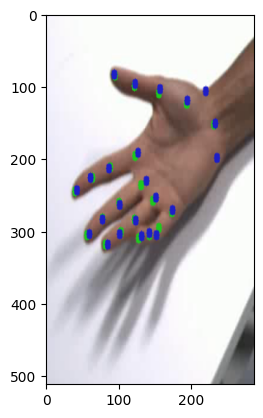

In [19]:
plt.imshow(results[1][0])
plt.imshow(results[2][0])
plt.imshow(results[3][0])
plt.imshow(results[4][0])
plt.imshow(results[5][0])
plt.imshow(results[6][0])
results[0][0].shape

In [23]:

def images_to_grid(images, n_cols=4):
    n_rows = int(np.ceil(len(images) / n_cols))
    grid = np.zeros((n_rows * images[0].shape[0], n_cols * images[0].shape[1], 3), dtype=np.uint8)
    len(images)
    for i, img in enumerate(images):
        row = i // n_cols
        col = i % n_cols
        grid[row * img.shape[0] : (row + 1) * img.shape[0], col * img.shape[1] : (col + 1) * img.shape[1], :] = img
    return grid

# collate the results into a grid
res = [images_to_grid(r) for r in zip(*results)]
# write the collated frames into a video matching the original frame rate using opencv VideoWriter
# fd, filename = tempfile.mkstemp(suffix=".mp4")
# shutil.move(filename, "collated_video.mp4")
# os.close(fd)
method = (HandPoseEstimationMethodLookup & key).fetch1('estimation_method_name')
prefix= ' '.join((SingleCameraVideo & key).fetch('filename')[0].split('_')[:2])

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(f'yj8_{prefix}_{method}.mp4', fourcc, 29, (res[0].shape[1], res[0].shape[0]))
for frame in tqdm(res, desc="Writing"):
    cv2.putText(frame,  
                method+'  |  green: 2d detections  |  blue: OpenSim',  
                (50, 50),  
                cv2.FONT_HERSHEY_SIMPLEX , 1,  
                (0, 255, 255),  
                2,  
                cv2.LINE_4) 
    writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
writer.release()
# os.remove(filename)



Writing: 100%|██████████| 933/933 [00:22<00:00, 41.01it/s]


In [28]:
kk = (HandPoseReconstruction & keys).fetch('KEY')

In [29]:
HandPoseReconstruction & kk[0]

recording_timestamps,camera_config_hash,cal_timestamp,reconstruction_method,estimation_method,detection_method,keypoints3d,camera_weights,reprojection_loss
2023-11-15 14:46:31,6222d5655b,2023-11-15 14:49:30,3,0,1,=BLOB=,=BLOB=,3.47692


In [30]:
from multi_camera.datajoint.multi_camera_dj import Calibration

from multi_camera.analysis.optimize_reconstruction import  reprojection_loss, smoothness_loss        


#Last 21 keypoints is the hand points
indx = [0,4,1,2,3]
# kp3dOsim = extract_from_osim("./smooth_ik_model_marker_locations.sto")
i = 0
for k, kp3dOsim in dic.items():
    # keys['estimation_method'] = indx[i].
    key = kk[indx[i]]
    i = i+1
    calibration_key = (HandPoseReconstruction & Calibration & key).fetch1("KEY")
    camera_calibration, camera_names = (Calibration & calibration_key).fetch1("camera_calibration", "camera_names")
    
    keypoints = (HandPoseEstimation & key).fetch('keypoints_2d')
    camera_name = (SingleCameraVideo * MultiCameraRecording * HandPoseEstimation & key).fetch('camera_name')

    # Combine the right and left hand keypoints!
    new_keypoints = []
    for camera_k in keypoints:
        new_keypoints.append(np.asarray([np.concatenate(frame_kp,axis=0) for frame_kp in camera_k]))
    keypoints = np.stack(new_keypoints)


    #pad zeros for all cameras
    N = max([len(k) for k in keypoints])
    keypoints = np.stack(
        [np.concatenate([k, np.zeros([N - k.shape[0], *k.shape[1:]])], axis=0) for k in keypoints], axis=0
    )

    # work out the order that matches the calibration (should normally match)
    order = [list(camera_name).index(c) for c in camera_names]
    points2d = np.stack([keypoints[o][:, :, :] for o in order], axis=0)

    #Get the right hand compared to Osim
    reproj_loss = reprojection_loss(camera_calibration, points2d[:,:,:21,:], kp3dOsim[:, -21:, :3], huber_max=100)
    from multi_camera.analysis import fit_quality
    metrics, thresh, confidence = fit_quality.reprojection_quality( kp3dOsim[:, -21:, :3], camera_calibration, points2d[:,:,:21,:])
    pck10 = metrics[np.argmin(np.abs(thresh - 10)), np.argmin(np.abs(confidence - 0.5))]
    pck5 = metrics[np.argmin(np.abs(thresh - 5)), np.argmin(np.abs(confidence - 0.5))]
    print(k)
    print((HandPoseEstimationMethodLookup & key).fetch('estimation_method_name'))

    print("reprojection loss= ", reproj_loss)
    print(f'precentage of points projected over 5 pixels = {pck5}')
    print(f'precentage of points projected over 10 pixels = {pck10}')

./data/RTMPOSEhand5
['RTMPoseHand5']
reprojection loss=  7.1227155
precentage of points projected over 5 pixels = 0.45424821972846985
precentage of points projected over 10 pixels = 0.7827877402305603
./data/HRNetUDP
['HRNet_udp']
reprojection loss=  18.550268
precentage of points projected over 5 pixels = 0.3742355406284332
precentage of points projected over 10 pixels = 0.6934082508087158
./data/RTMPOSEcoco
['RTMPoseCOCO']
reprojection loss=  3.5496504
precentage of points projected over 5 pixels = 0.48366886377334595
precentage of points projected over 10 pixels = 0.8185983896255493
./data/freihand
['freihand']
reprojection loss=  28.861895
precentage of points projected over 5 pixels = 0.21161653101444244
precentage of points projected over 10 pixels = 0.5342398285865784
./data/HRNetDark
['HRNet_dark']
reprojection loss=  23.798676
precentage of points projected over 5 pixels = 0.37301531434059143
precentage of points projected over 10 pixels = 0.6849345564842224


In [31]:
def get_joint_names_index(key, with_movi=True):
    # from hand_detection.hand_dj import HandPoseEstimation
    joint_names =  (HandPoseEstimation&key).joint_names()
    # joint_names = ['Wrist','CMC1','MCP1','IP1','TIP1','MCP2','PIP2',
    #     'DIP2', 'TIP2', 'MCP3', 'PIP3', 'DIP3','TIP3', 'MCP4',
    #     'PIP4', 'DIP4', 'TIP4', 'MCP5', 'PIP5','DIP5', 'TIP5'
    #     ]
    if with_movi:
        movi_joints= [  
                "R.clavicle",#2
                "R.Shoulder.M",#39
                "R.Elbow.Lateral",#41
                # "R.Forearm",#42
                "R.Wrist.Lateral.Thumb",#43
                "R.Wrist.Medial.pinky",#44
                "R.Elbow.Medial.Inner",#57
                    ]
        movi_inds = np.array((2,39,41,43,44,57))
        return movi_joints+joint_names, movi_inds
    
    return joint_names

In [32]:
# from body_models.biomechanics_mjx.implicit_fitting import get_joint_names_index
def fetch_keypoints(key, only_detected=True, only_fully_in_field=False, half_val=None, smoothness=None):
    """
    Fetches keypoints from the database and returns them as a dictionary of numpy arrays.

    Parameters:
        key (Dict): A dictionary with the keys to fetch the keypoints from the database.
        only_detected (bool): If True, only fetches data when detected on one camera.

    Returns:
        Dict: A dictionary with the keypoints.
    """

    from pose_pipeline.pipeline import TopDownPerson, TopDownMethodLookup, VideoInfo, PersonBbox
    from hand_detection.hand_dj import HandPoseEstimation, HandPoseEstimationMethodLookup
    from multi_camera.datajoint.multi_camera_dj import SingleCameraVideo, MultiCameraRecording

    tables = (SingleCameraVideo * MultiCameraRecording * HandPoseEstimation) 

    movi_tables = TopDownPerson * TopDownMethodLookup * SingleCameraVideo & 'top_down_method_name="Bridging_bml_movi_87"'
    assert len(tables & key) < 20
    keypoints = (tables & key).fetch("keypoints_2d")
    #Get movi indecies and keypoints for the joint names
    _ , moviinds = get_joint_names_index(key, with_movi=True)

    movi_keypoints = (movi_tables & key).fetch("keypoints")
    movi_keypoints = np.stack(
            [k[:,moviinds,:] for k in movi_keypoints], axis=0
        )
    # need to add zeros for missing frames at the end
    # N = max([len(k) for k in keypoints])
    # keypoints = np.stack(
    #     [np.concatenate([k, jnp.zeros([N - k.shape[0], *k.shape[1:]])], axis=0) for k in keypoints], axis=0
    # )
    # if half_val or smoothness:
        # keypoints = redo_keypoint_noise(key, half_val, smoothness)
    # Combine the right and left hand keypoints!
    new_keypoints = []
    for camera_k in keypoints:
        #ONLY GET THE RIGHT HAND
        new_keypoints.append(np.asarray([frame_kp[0] for frame_kp in camera_k]))
    keypoints = np.stack(new_keypoints)
    
    #combined movi and hand keypoints
    keypoints = np.concatenate((movi_keypoints,keypoints[:,:]),axis=2)

    # handle cases where there are different numbers of frames
    N = min([k.shape[0] for k in keypoints])
    keypoints = np.stack([k[:N] for k in keypoints], axis=0)

    info_key = (VideoInfo & (SingleCameraVideo * HandPoseEstimation * HandPoseEstimationMethodLookup & key)).fetch("KEY")[0]
    timestamps = (VideoInfo & info_key).fetch_timestamps()[:N]

    valid_keypoints = np.any(keypoints[..., -1] > 0, axis=(0, 2))  # across the cameras and joints

    # if only_fully_in_field:
    #     valid_before = np.mean(keypoints[..., -1]).item()
    #     tables = PersonBbox * VideoInfo * SingleCameraVideo
    #     bbox, present, height, width = (tables & key).fetch("bbox", "present", "height", "width")
    #     for i in range(len(bbox)):
    #         updated_present = update_present(bbox[i], present[i], height[i], width[i])
    #         keypoints = keypoints.at[i, ~updated_present, :, -1].set(0.0)

    #     valid_after = np.mean(keypoints[..., -1]).item()
    #     print(f"valid before: {valid_before} after: {valid_after}")

    if only_detected:
        keypoints = keypoints[:, valid_keypoints]
        timestamps = timestamps[valid_keypoints]

    return timestamps, keypoints

In [33]:
# from body_models.biomechanics_mjx.implicit_fitting import fetch_keypoints
from multi_camera.datajoint.multi_camera_dj import Calibration
from pose_pipeline.pipeline import Video, VideoInfo

# from body_models.biomechanics_mjx.implicit_fitting import reprojection_loss
import numpy as np
import cv2

videos = (HandPoseEstimation * MultiCameraRecording  * SingleCameraVideo & Recording & key).proj()
camera_params= (Recording * Calibration & key).fetch1("camera_calibration")
camera_names = (Recording * Calibration & key).fetch1("camera_names")


tvec = camera_params["tvec"]
rvec = camera_params["rvec"]
# Removed display function calls to prevent error
# Assuming camera_params['mtx'] and camera_params['dist'] are well-defined

# Convert rotation vectors to rotation matrices
rmats = [cv2.Rodrigues(np.array(r[None, :]))[0].T for r in rvec]

pos = np.array([-R.dot(t) for R, t in zip(rmats, tvec)])*1000

In [42]:
# indx = [0,4,1,2,3]
# kp3dOsim = extract_from_osim("./smooth_ik_model_marker_locations.sto")
i = 0
# for k, kp3dOsim in dic.items():
for key in kk:
    # keys['estimation_method'] = indx[i].
    # key = kk[i]
    i = i+1
    from matplotlib import pyplot as plt
    # key = res
    # for k in keys:
    #         k['estimation_method']=i
    # key = keys
    # pred_no_bundle = trajectory_no_bundle(timestamps, trajectory_selection=trajectory_selection, fast_inference=True)
    # timestamps, keypoints2d = fetch_keypoints(key)
    # pose = (MJXReconstruction & key).fetch1('qpos')
    # # pose = pose[:,6:]
    # pred = (MJXReconstruction & key).fetch1('sites')
    # tables = Recording *  HandPoseEstimation * HandPoseEstimationMethodLookup * HandPoseReconstructionMethodLookup
    # camera_params_mjx = res[0][1].get_calibration(True,True)
    #Last 21 keypoints is the hand points
    # trajectory = res[0]
    # pose = trajectory(timestamps, pose_only=True)
    # pred = trajectory(timestamps)
    # pose = (MJXReconstruction & key).fetch1('qpos')
    # # pose = pose[:,6:]
    # pred = (MJXReconstruction & key).fetch1('sites')
    # tables = Recording *  HandPoseEstimation * HandPoseEstimationMethodLookup * HandPoseReconstructionMethodLookup
    video_keys = (videos).fetch("KEY")
    fps = np.unique((VideoInfo & video_keys[0]).fetch1("fps"))
    width = np.unique((VideoInfo & video_keys).fetch("width"))[0]
    height = np.unique((VideoInfo & video_keys).fetch("height"))[0]
    from multi_camera.analysis.camera import project_distortion, get_intrinsic, get_extrinsic, distort_3d
    # from multi_camera.analysis.calibration import plot_cal
    camera_name = (SingleCameraVideo * MultiCameraRecording * HandPoseEstimation & key).fetch('camera_name')


    # kp3d = kp3dOsim
    # kp3d= kp3d[:,-21:,:]
    kp3d = (HandPoseReconstruction & key ).fetch1("keypoints3d")
    kp3d = kp3d[:,:21,:]

    keypoints = (HandPoseEstimation & key ).fetch("keypoints_2d")
    # Combine the right and left hand keypoints!
    new_keypoints = []
    for camera_k in keypoints:
        new_keypoints.append(np.asarray([np.concatenate(frame_kp,axis=0) for frame_kp in camera_k]))
    keypoints = np.stack(new_keypoints)
    #pad zeros for all cameras
    N = max([len(k) for k in keypoints])
    keypoints = np.stack(
        [np.concatenate([k, np.zeros([N - k.shape[0], *k.shape[1:]])], axis=0) for k in keypoints], axis=0
    )
    # work out the order that matches the calibration (should normally match)
    order = [list(camera_name).index(c) for c in camera_names]
    keypoints2d = np.stack([keypoints[o][:, :21, :] for o in order], axis=0)
    rvec = camera_params["rvec"]
    rmats = [cv2.Rodrigues(np.array(r[None, :]))[0].T for r in rvec]




    keypoints_2d_triangulated = np.array([project_distortion(camera_params, i, kp3d) for i in range(camera_params["mtx"].shape[0])])
    SC= []
    for ci in range(keypoints2d.shape[0]):
        
        # keypoints_coef = keypoints2d[ci,:,:, 2]
        # mask = keypoints_coef > 0.5
        # Extract the translation vector from the camera parameters
        # tvec = np.take(camera_params["tvec"], ci, axis=0) * 1000.0
        # Calculate the distance to the point
        distance = np.linalg.norm(pos[ci,:] - kp3d[...,:3], axis=-1)
        
        projection_error = keypoints_2d_triangulated[ci,:,:21,:2] - keypoints2d[ci,:,:, :2]
        # keypoint_conf = keypoints2d[ci,..., 2]
        intrinsics = get_intrinsic(camera_params,0)

        # Extract the focal lengths from the camera parameters
        focal_length_x = intrinsics[0, 0]  # assuming the focal length in x direction is at this location
        focal_length_y = intrinsics[1, 1]  # assuming the focal length in y direction is at this location

        # Calculate the FOVs
        fov_x = 2 * np.arctan(width / (2 * focal_length_x))
        fov_y = 2 * np.arctan(height / (2 * focal_length_y))
        # Calculate the degree of view for each pixel
        degree_per_pixel_x = fov_x / width
        degree_per_pixel_y = fov_y / height

        angular_error = np.array([degree_per_pixel_x, degree_per_pixel_y]) * projection_error
        # Calculate the spatial errors
        spatial_error_x = distance * np.tan(angular_error[...,0])
        spatial_error_y = distance * np.tan(angular_error[...,1])
        spatial_error = np.linalg.norm(np.array([spatial_error_x, spatial_error_y]),axis=0)
        # print(spatial_error.shape)
        # Calculate the widths of the view at the distance of the object
        # width_of_view_x = 2 * distance * np.tan(fov_x / 2)
        # width_of_view_y = 2 * distance * np.tan(fov_y / 2)
        # print('camera', ci, 'median error: ', np.median(spatial_error), 'mm')
        # # Calculate the spatial errors
        # spatial_error_x = (projection_error[...,0] / width) * width_of_view_x
        # spatial_error_y = (projection_error[...,0] / height) * width_of_view_y
        SC.append(np.median(spatial_error))
    print((HandPoseEstimationMethodLookup & key).fetch('estimation_method_name'))
    # print(k)

    print('median error: ', np.median(SC), 'mm')

['RTMPoseHand5']
median error:  3.1625634191782312 mm
['RTMPoseCOCO']
median error:  4.656150589961827 mm
['freihand']
median error:  7.174548656372294 mm
['HRNet_dark']
median error:  3.2409541081113096 mm
['HRNet_udp']
median error:  3.961787675277394 mm


In [43]:
indx = [0,4,1,2,3]
i = 0
for k, kp3dOsim in dic.items():
    key = kk[i]
    i = i+1
    from matplotlib import pyplot as plt
    # key = res

    timestamps, keypoints2d = fetch_keypoints(key)
    # pose = (MJXReconstruction & key).fetch1('qpos')
    # pose = pose[:,6:]
    # pred = (MJXReconstruction & key).fetch1('sites')
    tables = Recording *  HandPoseEstimation * HandPoseEstimationMethodLookup * HandPoseReconstructionMethodLookup
    
    kp3d = kp3dOsim
    kp3d = kp3d[:,-21:,:3]

    #get only the hand keypoints
    # kp3d= pred[:,-21:,:3]
    # keypoints3d = (HandPoseReconstruction & key ).fetch1("keypoints3d")/1000.0
    # keypoints3d = keypoints3d[:,:21,:3]
    point_difference = np.diff(kp3d, axis=0)**2
    diff_sum = np.mean(point_difference, axis=0) 
    Noise_mjx = np.mean(diff_sum, axis=0)
    
    # point_difference = np.diff(keypoints3d, axis=0)**2
    # diff_sum = np.mean(point_difference, axis=0) 
    # Noise_tri = np.mean(diff_sum, axis=0)

    print('Osim')
    print((HandPoseEstimationMethodLookup & key).fetch('estimation_method_name'))
    print(np.sqrt(np.mean(Noise_mjx)))
    # print('TRIANGULATION')
    # print((HandPoseEstimationMethodLookup & key).fetch('estimation_method_name'))
    # print(np.sqrt(np.mean(Noise_tri)))

Osim
['RTMPoseHand5']
2.7430055679305734
Osim
['RTMPoseCOCO']
3.183292390367356
Osim
['freihand']
2.5032847350225347
Osim
['HRNet_dark']
3.805673933309873
Osim
['HRNet_udp']
2.6876179475175905


In [56]:
HandPoseReconstructionAnalysis & keys

recording_timestamps,camera_config_hash,cal_timestamp,reconstruction_method,estimation_method,detection_method,pk_5,pk_10,pcks,spatial_loss,pose_noise
2024-05-24 13:58:33,39932d9e29,2024-05-24 16:46:21,3,0,1,0.735438,0.970294,=BLOB=,4.3811,0.00171471
2024-05-24 14:02:04,39932d9e29,2024-05-24 16:46:21,3,0,1,0.633883,0.95874,=BLOB=,6.5915,0.636728
2024-05-24 14:03:52,39932d9e29,2024-05-24 16:46:21,3,0,1,0.644502,0.959394,=BLOB=,4.20884,0.0412984
2024-05-24 14:08:23,39932d9e29,2024-05-24 16:46:21,3,0,1,0.767285,0.979365,=BLOB=,4.76254,0.59292
2024-05-24 14:41:59,39932d9e29,2024-05-24 16:46:21,3,0,1,0.782703,0.977937,=BLOB=,4.90343,0.353103
2024-05-24 14:43:09,39932d9e29,2024-05-24 16:46:21,3,0,1,0.737639,0.972033,=BLOB=,4.12925,0.00200218
2024-05-24 14:52:03,39932d9e29,2024-05-24 16:46:21,3,0,1,0.861295,0.982466,=BLOB=,3.77156,0.00345544
2024-05-24 15:16:42,39932d9e29,2024-05-24 16:46:21,3,0,1,0.608126,0.9706,=BLOB=,12.6354,1.0195
2024-05-24 15:16:42,39932d9e29,2024-05-24 16:46:21,3,1,1,0.664046,0.993043,=BLOB=,82.7402,6.58887
2024-05-24 15:22:35,39932d9e29,2024-05-24 16:46:21,3,0,1,0.721109,0.973318,=BLOB=,3.30279,0.00308063


In [4]:
key = keys[-1]
SingleCameraVideo & key

recording_timestamps,camera_config_hash,video_project,filename,camera_name,frame_timestamps
2024-05-24 14:02:04,39932d9e29,HAND_TEST,yj843_L_20240524_140204.23015083,23015083,=BLOB=
2024-05-24 14:02:04,39932d9e29,HAND_TEST,yj843_L_20240524_140204.23015089,23015089,=BLOB=
2024-05-24 14:02:04,39932d9e29,HAND_TEST,yj843_L_20240524_140204.23106526,23106526,=BLOB=
2024-05-24 14:02:04,39932d9e29,HAND_TEST,yj843_L_20240524_140204.23106528,23106528,=BLOB=
2024-05-24 14:02:04,39932d9e29,HAND_TEST,yj843_L_20240524_140204.23106530,23106530,=BLOB=
2024-05-24 14:02:04,39932d9e29,HAND_TEST,yj843_L_20240524_140204.23106542,23106542,=BLOB=
2024-05-24 14:02:04,39932d9e29,HAND_TEST,yj843_L_20240524_140204.23106544,23106544,=BLOB=
2024-05-24 14:02:04,39932d9e29,HAND_TEST,yj843_L_20240524_140204.23336088,23336088,=BLOB=


In [10]:
keys = (OpenSimReconstruction).fetch('KEY')

In [13]:
from pose_pipeline import  VideoInfo
from multi_camera.datajoint.sessions import Recording
from multi_camera.analysis import fit_quality
import cv2
from multi_camera.analysis.camera import project_distortion, get_intrinsic, get_extrinsic, distort_3d
key = keys[1]
kp3d = (OpenSimReconstruction & key).fetch1('keypoints')
# tables = Recording *  HandPoseEstimation * HandPoseEstimationMethodLookup * HandPoseReconstructionMethodLookup
camera_name = (SingleCameraVideo * MultiCameraRecording * HandPoseEstimation & key).fetch('camera_name')

#First 21 keypoints is the right hand points
kp3d = kp3d[:, -21:, :3]
calibration_key = (CalibratedRecording & key).fetch1("KEY")
camera_params, camera_names = (Calibration & calibration_key).fetch1("camera_calibration", "camera_names")

keypointsHPE = (HandPoseEstimation & key).fetch('keypoints_2d')
#pad zeros for all cameras
N = max([len(k) for k in keypointsHPE])
keypointsHPE = np.stack(
    [np.concatenate([k, np.zeros([N - k.shape[0], *k.shape[1:]])], axis=0) for k in keypointsHPE], axis=0
)

#pad zeros for 3d keypoints
kp3d = np.concatenate([kp3d, np.zeros([N - kp3d.shape[0], *kp3d.shape[1:]])], axis=0)

# work out the order that matches the calibration (should normally match)
order = [list(camera_name).index(c) for c in camera_names]
points2d = np.stack([keypointsHPE[o][:, :21, :] for o in order], axis=0)

#Get the right hand compared to 3d keypoints
metrics2, thresh, confidence = fit_quality.reprojection_quality( kp3d[:, :, :3], camera_params, points2d[:,:,:21,:])
pck10 = metrics2[np.argmin(np.abs(thresh - 10)), np.argmin(np.abs(confidence - 0.5))]
pck5 = metrics2[np.argmin(np.abs(thresh - 5)), np.argmin(np.abs(confidence - 0.5))]
pcks = np.array([metrics2[np.argmin(np.abs(thresh - i)), np.argmin(np.abs(confidence - 0.5))].item() for i in range(16)])


#SETTING UP CALCULATION FOR SPATIAL ERROR
videos = (HandPoseEstimation * MultiCameraRecording  * SingleCameraVideo & Recording & key).proj()
keypoints2d = points2d
rvec = camera_params["rvec"]
rmats = [cv2.Rodrigues(np.array(r[None, :]))[0].T for r in rvec]

tvec = camera_params["tvec"]
rvec = camera_params["rvec"]
# Removed display function calls to prevent error
# Assuming camera_params['mtx'] and camera_params['dist'] are well-defined
video_keys = (videos).fetch("KEY")
fps = np.unique((VideoInfo & video_keys[0]).fetch1("fps"))
width = np.unique((VideoInfo & video_keys).fetch("width"))[0]
height = np.unique((VideoInfo & video_keys).fetch("height"))[0]

# Convert rotation vectors to rotation matrices
rmats = [cv2.Rodrigues(np.array(r[None, :]))[0].T for r in rvec]

pos = np.array([-R.dot(t) for R, t in zip(rmats, tvec)])*1000

#CALCULATING THE SPATIAL ERROR
keypoints_2d_triangulated = np.array([project_distortion(camera_params, i, kp3d) for i in range(camera_params["mtx"].shape[0])])
SC= []
for ci in range(keypoints2d.shape[0]):
    
    # Extract the translation vector from the camera parameters
    # Calculate the distance to the point
    distance = np.linalg.norm(pos[ci,:] - kp3d[...,:3], axis=-1)
    
    projection_error = keypoints_2d_triangulated[ci,:,:21,:2] - keypoints2d[ci,:,:, :2]
    # keypoint_conf = keypoints2d[ci,..., 2]
    intrinsics = get_intrinsic(camera_params,ci)

    # Extract the focal lengths from the camera parameters
    focal_length_x = intrinsics[0, 0]  # assuming the focal length in x direction is at this location
    focal_length_y = intrinsics[1, 1]  # assuming the focal length in y direction is at this location

    # Calculate the FOVs
    fov_x = 2 * np.arctan(width / (2 * focal_length_x))
    fov_y = 2 * np.arctan(height / (2 * focal_length_y))
    # Calculate the degree of view for each pixel
    degree_per_pixel_x = fov_x / width
    degree_per_pixel_y = fov_y / height

    angular_error = np.array([degree_per_pixel_x, degree_per_pixel_y]) * projection_error
    # Calculate the spatial errors
    spatial_error_x = distance * np.tan(angular_error[...,0])
    spatial_error_y = distance * np.tan(angular_error[...,1])
    spatial_error = np.linalg.norm(np.array([spatial_error_x, spatial_error_y]),axis=0)
    # Calculate the widths of the view at the distance of the object
    # print('camera', ci, 'median error: ', np.median(spatial_error), 'mm')
    # # Calculate the spatial errors
    SC.append(np.mean(spatial_error))

#CALCULATING THE NOISE
point_difference = np.diff(kp3d/1000, axis=0)**2
diff_sum = np.sum(point_difference, axis=0) 
Noise_mjx = np.mean(diff_sum, axis=0)


In [14]:
SC

[87.52214479872177,
 91.34866864048479,
 68.33945303797371,
 92.28573304237942,
 95.29685016932666,
 125.3762905095143,
 94.41065602045721,
 73.13506803072362]

In [47]:
(OpenSimReconstruction& keys[1]).delete()

[2024-06-08 17:32:52,159][INFO]: Deleting 1 rows from `hand_detection`.`__open_sim_reconstruction`
[2024-06-08 17:32:54,078][INFO]: Deletes committed.


1

In [9]:
OpenSimReconstruction()


recording_timestamps,camera_config_hash,cal_timestamp,reconstruction_method,estimation_method,detection_method,keypoints
2024-05-24 14:06:15,39932d9e29,2024-05-24 16:46:21,3,0,1,=BLOB=
2024-05-24 14:06:15,39932d9e29,2024-05-24 16:46:21,3,1,1,=BLOB=
2024-05-24 14:10:16,39932d9e29,2024-05-24 16:46:21,3,0,1,=BLOB=
2024-05-24 14:10:16,39932d9e29,2024-05-24 16:46:21,3,1,1,=BLOB=
